In [1]:
import pandas as pd
import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem import Scaffolds
from rdkit.Chem.Scaffolds import rdScaffoldNetwork
from rdkit.Chem.Scaffolds import MurckoScaffold as ms 
from rdkit.Chem.Descriptors import ExactMolWt
import os
import time
from multiprocessing import Pool, TimeoutError, Manager
from functools import partial
import matplotlib.pyplot as plt
import pubchempy as pcp
from matplotlib import ticker
import random
import json
import numpy as np
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import pickle
from IPython.display import clear_output

clear_output()

In [ ]:

## specify target to evaluate
target='app'
# target='tau'

base_folder="/home/paperspace/Desktop/DL_Project/final_outputs/"

if target=='app':
    result_folder="12_25_2023-16_39_app_[64, 128, 64]_0_True_128_500_150_results/"
    file_name="12_25_2023-16_39_app_[64, 128, 64]_0_True_128_500_150_results_file.txt"

else:
    result_folder="12_25_2023-14_55_tau_[64, 64, 64, 64]_0_False_256_500_150_results/"
    file_name="12_25_2023-14_55_tau_[64, 64, 64, 64]_0_False_256_500_150_results_file.txt"

results_file=base_folder+result_folder+file_name

with open(f"{results_file}", "r") as f:
    try:
        outputs=json.load(f)
        print("data loaded")
        print(outputs.keys())
    except:
        print("error loading results")

### General Functions

In [2]:
def extract_numeric_performance(all_data_dictionary: dict) -> list:
    """
    Called from within plot_performance function
    """
    # the last digit is how often the model was evaluated (eg: every 3rd epoc)
    epochs = list(all_data_dictionary['results'].keys())
    epoch_numbers=epochs
    overall_data={}
    overall_data['epochs']=epoch_numbers
    # data_to_plot = defaultdict(list)
    # data_to_plot['epochs']=epoch_numbers

    # then will pull out "validation" "test" dictionaries
    for dataset in ['training', 'validation', 'test']:
        data_to_plot = defaultdict(list)
        # data_to_plot['epochs']=epoch_numbers
        overall_data[dataset]={}
        for key, val in all_data_dictionary['results'].items():
            
            # data_to_plot['roc_auc_vals'].append(all_data_dictionary['results'][key][dataset]['roc_auc_score'])
            data_to_plot['num_predicted_hits'].append(all_data_dictionary['results'][key][dataset]['num_predicted_hits'])
            data_to_plot['true_positive_list'].append(all_data_dictionary['results'][key][dataset]['num_true_positives'])
            data_to_plot['loss_vals'].append(all_data_dictionary['results'][key][dataset]['log_loss'])
            # data_to_plot['accuracy_vals'].append(all_data_dictionary['results'][key]['accuracy'])
            data_to_plot['precision_vals'].append(all_data_dictionary['results'][key][dataset]['precision (TP/(TP + FP))'])
            data_to_plot['recall_vals'].append(all_data_dictionary['results'][key][dataset]['recall (TP/TP + FN))'])

        overall_data[dataset]=data_to_plot
    return overall_data

### Visualize Precision and Recall for Training and Validation

In [ ]:
outputs['results'].keys()

In [ ]:
epochs=130
training_losses=[]
validation_losses=[]
for epoch in range(5, epochs+1, 5):
    training_losses.append(outputs['results'][f'{epoch}']['training']['log_loss'])
    validation_losses.append(outputs['results'][f'{epoch}']['validation']['log_loss'])

In [ ]:
extract_numeric_performance(outputs).keys()

In [3]:
def plot_performance(all_data_dictionary: dict, save_image=False, target='APP'):
    """
    abadafd
    """
    plt.style.use("ggplot")

    data_to_plot=extract_numeric_performance(all_data_dictionary)
    epochs=data_to_plot['epochs']

    title_size=11
    label_size=10
    fig, ax = plt.subplots(2, 1, figsize = (4, 5), tight_layout = True, sharey=False)
    # plt.setp(ax, xlabel='Epochs')
    
    for data_set, row in zip(['training', 'validation'], [0, 1]):

        ax[row].plot(epochs, data_to_plot[data_set][f'recall_vals'], label = 'recall')
        ax[row].plot(epochs, data_to_plot[data_set][f'precision_vals'], label = 'precision')
        ax[row].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax[row].set_ylim([0, 1])
        ax[row].set_ylabel("Metric Performance", size=label_size)
        ax[row].set_xlabel("Epochs", size=label_size)
        ax[row].set_title(f"{target} - {data_set.title()} Set Precision and Recall", size=title_size)
        ax[row].legend()

    
    if save_image:
        plt.savefig(f"{target}_model_performance.png", dpi=400)

    plt.show()  

In [ ]:
plot_performance(outputs, save_image=False, target='Tau')

### Visualize Active Compound Probabilities Over Epochs

In [ ]:
outputs.keys()

In [ ]:
validation_truth=outputs['model_parameters']['validation_true_labels']
true_pos_indices=[i for i in range(len(validation_truth)) if validation_truth[i]==1]

In [ ]:
outputs['results'].keys()

In [ ]:
# [inactive_probability, active_probability]
## retrieve just active predictions
plt.style.use("ggplot")

# target="tau"

# epoch_numbers = [int(x) for x in outputs['results'].keys()]
# epoch_numbers = [5] + [i for i in range(10, 101, 10)]
# epoch_samples = [2] + [i for i in epoch_numbers if i%10 == 0]
# epoch_samples = [i for i in epoch_numbers if i%10 == 0]
epoch_numbers = [5] + [i for i in range(10, 101, 10)]
epoch_samples=epoch_numbers
num_data_points=len(epoch_samples)
num_cols=np.ceil(num_data_points/2)

fig, ax = plt.subplots(2, int(num_cols), figsize=(15, 6), tight_layout=True)

row=0
col=0
for epoch in epoch_samples:

    preds=outputs['results'][f'{epoch}']['validation']['predictions']
    active_probabilities=[i[0][1] for i in preds]
    true_hit_probs=[]

    for index in true_pos_indices:
        true_hit_probs.append(preds[index])

    true_hit_probs=[i[0][1] for i in true_hit_probs]

    ax[row][col].hist(active_probabilities, bins=50, density=True, alpha=.5, color='orange', label='All Compounds')
    ax[row][col].hist(true_hit_probs, bins=50, color='blue', density=True, alpha=.5, label='True Hits')
    ax[row][col].axvline(x=0.2, color='black', label="Classification\nThreshold")
    ax[row][col].set_title(f"Epoch {epoch}", size=11)
    
    col +=1
    if col==num_cols:
        col=0
        row+=1

plt.suptitle(f'Validation Set Hit Probability Distributions for APP Inhibition. Probabilities greater than 0.2 are classified as a Hit (Inhibits APP)', size=14)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines_labels=[lines_labels[0]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(.855,.2), fontsize=12)
fig.delaxes(ax[1,5])

plt.savefig("Validation_Probability_Shifts_Over_Epochs_APP.png", dpi=400)
plt.show()

### Molecular Properties

In [ ]:
properties=pd.read_pickle("../data/cleaned_smiles_both_assays_pubchem_fp_chembl_pca_2023_Dec25.pickle")

In [ ]:
# properties['Aromatic Rings'].isnull().sum()
properties['Aromatic Rings']=properties['Aromatic Rings'].replace("None", np.nan)
properties['Aromatic Rings']=properties['Aromatic Rings'].astype(float)

In [ ]:
# separate into dataframes for active and inactive compounds

active_app = properties[properties['app_inhibitor'] == 'Active']
active_tau = properties[properties['tau_inhibitor'] == 'Active']

inactive_app = properties[properties['app_inhibitor'] == 'Inactive']
inactive_tau = properties[properties['tau_inhibitor'] == 'Inactive']

inactive_both = properties[(properties['app_inhibitor'] == 'Inactive') & (properties['tau_inhibitor'] == 'Inactive')]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# joint_kws = {'scatter_kws':dict(alpha=0.5, edgecolor='none')}

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False, tight_layout=True)

sns.distplot(active_app['mw'], ax=axes[0, 0], label='APP inhibitor', color='blue')
sns.distplot(active_tau['mw'], ax=axes[0, 0], label='Tau inhibitor', color='orange')
sns.distplot(inactive_both['mw'], ax=axes[0, 0], label='Inactive', color='green')
axes[0, 0].set_title("Molecular Weight")
axes[0, 0].legend()

sns.distplot(active_app['polararea'], ax=axes[0, 1], label='APP inhibitor', color='blue')
sns.distplot(active_tau['polararea'], ax=axes[0, 1], label='Tau inhibitor', color='orange')
sns.distplot(inactive_both['polararea'], ax=axes[0, 1], label='Inactive', color='green')
axes[0, 1].set_title("Polar Surface Area")
axes[0, 1].legend()

sns.distplot(active_app['xlogp'], ax=axes[0, 2], label='APP inhibitor', color='blue')
sns.distplot(active_tau['xlogp'], ax=axes[0, 2], label='Tau inhibitor', color='orange')
sns.distplot(inactive_both['xlogp'], ax=axes[0, 2], label='Inactive', color='green')
axes[0, 2].set_title("XlogP")
axes[0, 2].legend()

# sns.histplot(active_app['Aromatic Rings'], ax=axes[1,0], label='APP inhibitor',
#              stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none')
# sns.histplot(active_tau['Aromatic Rings'], ax=axes[1,0], label='Tau inhibitor',
#              stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none')
sns.histplot(inactive_both['Aromatic Rings'], ax=axes[1,0], label='Inactive',
             stat="density", bins=15, color = 'green', alpha=0.4, edgecolor='none')
axes[1,0].set_title("Aromatic Rings Count")
axes[1,0].legend()

sns.histplot(active_app['hbonddonor'], ax=axes[1, 1], label='APP inhibitor',
             stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none')
sns.histplot(active_tau['hbonddonor'], ax=axes[1, 1], label='Tau inhibitor',
             stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none')
sns.histplot(inactive_both['hbonddonor'], ax=axes[1, 1], label='Inactive',
             stat="density", bins=15, color = 'green', alpha=0.4, edgecolor='none')
axes[1, 1].set_title("Hydrogen Bond Donor Count")
axes[1, 1].legend()

sns.histplot(active_app['rotbonds'], ax=axes[1, 2], label='APP inhibitor',
             stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none')
sns.histplot(active_tau['rotbonds'], ax=axes[1, 2], label='Tau inhibitor',
             stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none')
sns.histplot(inactive_both['rotbonds'], ax=axes[1, 2], label='Inactive',
             stat="density", bins=15, color = 'green', alpha=0.4, edgecolor='none')
axes[1, 2].set_title("Number of Rotatable Bonds")
axes[1, 2].legend()

plt.show()

### Principal Component Analysis

In [ ]:
# properties[properties['app_inhibitor']=='Active']

In [ ]:
plt.style.use("ggplot")
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(4)
# plt.rcParams.update({'font.size': 12})

plt.scatter(properties['first_component_pca'], properties['second_component_pca'], label = 'All compounds', s=2, color = 'darkgray', alpha=0.4)
plt.scatter(properties[properties['app_inhibitor']=='Active']['first_component_pca'], \
    properties[properties['app_inhibitor']=='Active']['second_component_pca'], 
    label='APP inhibitor', s=6, color = 'red')
plt.scatter(properties[properties['tau_inhibitor']=='Active']['first_component_pca'], \
    properties[properties['tau_inhibitor']=='Active']['second_component_pca'], \
        label = 'Tau inhibitor', s=6, alpha=0.8, color='blue')

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.title("Principal Components of Morgan Fingerprints\n", size=13)
plt.show()

In [ ]:
drugbank=pd.read_pickle("../data/full_prediction_set_fp_graphs.pickle")

#### Generate PCA for Drugbank

In [ ]:
with open('../final_outputs/pca_model_smiles_cleaned_2023Dec25.pkl', 'rb') as f:
    pretrained_pca = pickle.load(f)

In [ ]:
morgan_df_vals = drugbank['morgan_fp'].values.tolist()

## 5 minutes
def generate_int_fp(lst, data):

    lst.append(list(map(int, data)))


if __name__ == '__main__':

    pbar = tqdm(total=len(drugbank)/8)
    dfs_list = Manager().list()
    pool = Pool(processes=8)
    res = pool.map_async(partial(generate_int_fp, dfs_list), morgan_df_vals)
    res.wait()
    pbar.close()
    fp_df = pd.DataFrame(list(dfs_list))

fp_df.head()

In [ ]:
### reduce the fps to 3 dimensions
drugbank_reduced=pretrained_pca.transform(fp_df)

drugbank['first_component_pca'] = [i[0] for i in drugbank_reduced]
drugbank['second_component_pca'] = [i[1] for i in drugbank_reduced]
drugbank['third_component_pca'] = [i[2] for i in drugbank_reduced]

In [ ]:
plt.style.use("ggplot")
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(4)

plt.scatter(properties['first_component_pca'], properties['second_component_pca'], label = 'All compounds', s=2, color = 'darkgray', alpha=0.4)
plt.scatter(drugbank['first_component_pca'], drugbank['second_component_pca'], label = 'DrugBank', s=2, color = 'red', alpha=0.4)

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.title("Principal Components of Morgan Fingerprints\n", size=12)
plt.show()

In [ ]:
app_admet=pd.read_excel("../final_outputs/app_predictions_flagged_admet_14Jan2024.xlsx")
app_active=app_admet[app_admet['prediction']=='Active']
app_active.head()

In [ ]:
tau_admet=pd.read_excel("../final_outputs/tau_predictions_flagged_admet_14Jan2024.xlsx")
tau_active=tau_admet[tau_admet['prediction']=='Active']
tau_active.head()

In [ ]:
app_pca=app_active.merge(drugbank, how='left', on='inchikey')
tau_pca=tau_active.merge(drugbank, how='left', on='inchikey')

In [ ]:
# app_pca

In [ ]:
plt.style.use("ggplot")
f = plt.figure()
f.set_figwidth(4)
f.set_figheight(4)

plt.scatter(properties['first_component_pca'], properties['second_component_pca'], label = 'All compounds', s=2, color = 'darkgray', alpha=0.4)
plt.scatter(tau_pca['first_component_pca'], tau_pca['second_component_pca'], label = 'Tau Predicted Hit', s=2, color = 'blue', alpha=0.8)
plt.scatter(app_pca['first_component_pca'], app_pca['second_component_pca'], label = 'APP Predicted Hit', s=2, color = 'red', alpha=0.8)

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.title("Principal Components of Morgan Fingerprints\n", size=12)
plt.show()

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharex=True)

ax[0].scatter(properties['first_component_pca'], properties['second_component_pca'], label = 'Training Data', s=2, color = 'darkgray', alpha=0.4)
ax[0].scatter(drugbank['first_component_pca'], drugbank['second_component_pca'], label = 'DrugBank', s=2, color = 'red', alpha=0.4)
ax[0].set_title("All of Drugbank", size=12)
ax[0].legend()

ax[1].scatter(properties['first_component_pca'], properties['second_component_pca'], label = 'Training Data', s=2, color = 'darkgray', alpha=0.4)
ax[1].scatter(tau_pca['first_component_pca'], tau_pca['second_component_pca'], label = 'Tau Predicted Hit', s=2, color = 'blue', alpha=0.8)
ax[1].scatter(app_pca['first_component_pca'], app_pca['second_component_pca'], label = 'APP Predicted Hit', s=2, color = 'red', alpha=0.8)
ax[1].set_title("DrugBank Predicted Nominations", size=12)
ax[1].legend()

fig.suptitle("Principal Components of Morgan Fingerprints for DrugBank Prediction Set", size=13)

for subplot in ax:
    subplot.set_xlabel("First component", size=11)
    subplot.set_ylabel("Second component", size=11)

plt.savefig("Nominations_Scatterplot_14Jan2024.png", dpi=400)
plt.show()

In [ ]:
drugbank.columns

In [ ]:
prediction_set=pd.read_csv("../data/drugbank_w_molecular_properties_2023Dec26.csv")

In [ ]:
properties['mw'].isnull().sum()

In [ ]:
props_to_compare=['molecular_weight', '#Rotatable Bonds', 'CX LogP', 'HBA', 'HBD']

In [ ]:
for col in props_to_compare:
    print(col)
    print(prediction_set[col].isnull().sum())
    print(np.round(prediction_set[col].isnull().sum() / len(prediction_set), 3))
    print("_--------------")
    # print(len(properties))

In [ ]:
### will need to make sure they are all named the same (mw changed to molecular_weight)
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False, tight_layout=True)

row=0
for prop in props_to_compare:
    for col, label, source in zip([0, 1], ['Training Set', 'Prediction Set'],[properties, prediction_set])

    sns.distplot(source[prop], ax=axes[0, 0], label='APP inhibitor')

sns.distplot(chembl_active_app['molecular_weight'], ax=axes[0, 0], label='APP inhibitor')
sns.distplot(chembl_active_tau['molecular_weight'], ax=axes[0, 0], label='Tau inhibitor')
axes[0, 0].set_title("Molecular Weight")
axes[0, 0].legend()

sns.distplot(chembl_active_app['CX Acidic pKa'], ax=axes[0, 1], label='APP inhibitor')
sns.distplot(chembl_active_tau['CX Acidic pKa'], ax=axes[0, 1], label='Tau inhibitor')
axes[0, 1].set_title("CX Acidic pKa")
axes[0, 1].legend()

sns.distplot(chembl_active_app['CX Basic pKa'], ax=axes[0, 2], label='APP inhibitor')
sns.distplot(chembl_active_tau['CX Basic pKa'], ax=axes[0, 2], label='Tau inhibitor')
axes[0, 2].set_title("CX Basic pKa")
axes[0, 2].legend()

sns.distplot(chembl_active_app['CX LogD'], ax=axes[1, 0], label='APP inhibitor')
sns.distplot(chembl_active_tau['CX LogD'], ax=axes[1, 0], label='Tau inhibitor')
axes[1, 0].set_title("CX LogD")
axes[1, 0].legend()

sns.histplot(chembl_active_app['Aromatic Rings'], ax=axes[1, 1], label='APP inhibitor',
             stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none', discrete = True)
sns.histplot(chembl_active_tau['Aromatic Rings'], ax=axes[1, 1], label='Tau inhibitor',
             stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none', discrete = True)
axes[1, 1].set_title("Aromatic Rings")
axes[1, 1].legend()

sns.histplot(chembl_active_app['#RO5 Violations'], ax=axes[1, 2], label='APP inhibitor',
             stat="density", bins=15, color = 'blue', alpha=0.4, edgecolor='none', discrete = True)
sns.histplot(chembl_active_tau['#RO5 Violations'], ax=axes[1, 2], label='Tau inhibitor',
             stat="density", bins=15, color='orange', alpha=0.4, edgecolor='none', discrete = True)
axes[1, 2].set_title("#RO5 Violations")
axes[1, 2].legend()

plt.show()

### Bits to Structure

In [ ]:
# example_compound = caffeine
# from http://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html

caffeine_smiles='CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

caffeine = Chem.MolFromSmiles(caffeine_smiles)

display(caffeine)

# show 12 of the set bits
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(caffeine, radius=2, bitInfo=bi)
print(f"Indices where the morgan fingeprint bit vector = 1")
print(list(fp.GetOnBits())[:12])

tpls = [(caffeine,x,bi) for x in fp.GetOnBits()]
x=Draw.DrawMorganBits(tpls[:12],molsPerRow=6,legends=[str(x) for x in fp.GetOnBits()][:12])

In [ ]:
# dir(x)
# x.save("caffeine_by_bits.png")

In [ ]:

caffeine_img = rdkit.Chem.Draw.MolToImageFile(caffeine, "caffeine_img.png", dpi=400)
caffeine_img

### ADMET Differences

Text(0.5, 0, 'Predicted ADMET Score')

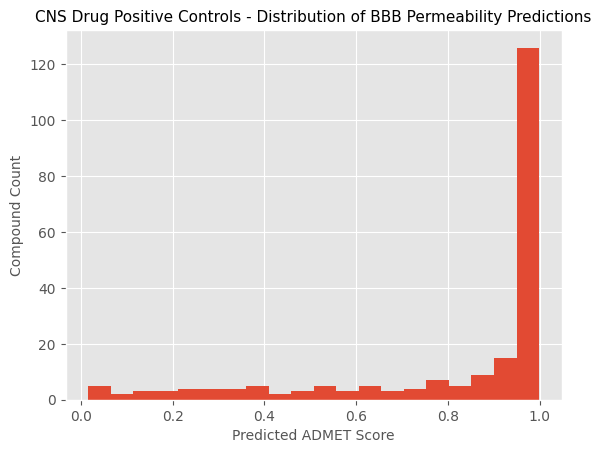

In [4]:
plt.style.use("ggplot")
cns_admet=pd.read_csv("../final_outputs/partial_data/ADMET_Lab2_CNS_drugs.csv")
cns_admet['BBB'].hist(bins=20)
plt.title(f"CNS Drug Positive Controls - Distribution of BBB Permeability Predictions", size=11)
plt.ylabel("Compound Count", size=10)
plt.xlabel("Predicted ADMET Score", size=10)

In [5]:
cns_admet

,smiles,LogS,LogD,LogP,Pgp-inh,Pgp-sub,HIA,F(20%),F(30%),Caco-2,...,MCE-18,Natural Product-likeness,Alarm_NMR,BMS,Chelating,PAINS,Lipinski,Pfizer,GSK,GoldenTriangle
0,CC1=C(CC(=O)O)c2cc(F)ccc2C1=Cc1ccc([S+](C)[O-]...,-4.824,1.240,3.511,0.002,0.919,0.024,0.010,0.028,-4.629,...,57.000,-0.291,1,0,0,0,Accepted,Rejected,Accepted,Accepted
1,C[C@@](Cc1ccc(O)c(O)c1)(NN)C(=O)O,-1.201,-0.393,-1.681,0.000,0.013,0.007,0.008,0.003,-5.821,...,20.000,0.656,2,1,1,1,Accepted,Accepted,Accepted,Accepted
2,O=c1[nH]c(O)cn1N=Cc1ccc(-c2ccc([N+](=O)[O-])cc...,-3.823,2.214,2.663,0.001,0.003,0.017,0.008,0.004,-4.832,...,17.000,-1.185,1,0,0,0,Accepted,Accepted,Accepted,Accepted
3,Cc1ccsc1C(=CCCN1CCCC(C(=O)O)C1)c1sccc1C,-4.489,3.774,4.382,0.002,0.012,0.013,0.082,0.007,-5.893,...,56.862,-0.624,1,0,0,0,Accepted,Rejected,Rejected,Accepted
4,Cc1c[nH]c(=NC(=O)C2C(=O)c3ccccc3S(=O)(=O)N2C)s1,-2.572,0.659,1.681,0.016,0.004,0.004,0.002,0.004,-4.997,...,62.353,-1.205,6,0,0,0,Accepted,Accepted,Accepted,Accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,CCC1(C)CC(=O)NC1=O,-0.896,0.460,0.541,0.024,0.001,0.004,0.001,0.001,-4.534,...,18.667,0.546,1,0,0,0,Accepted,Accepted,Accepted,Rejected
213,CN1C(=O)CC(C)(c2ccccc2)C1=O,-2.766,1.318,1.964,0.064,0.038,0.004,0.004,0.002,-4.644,...,42.250,0.215,1,0,0,0,Accepted,Accepted,Accepted,Accepted
214,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,-2.177,0.984,1.467,0.003,0.921,0.006,0.001,0.001,-5.070,...,27.733,0.068,0,0,0,0,Accepted,Accepted,Accepted,Accepted
215,CN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,-4.711,3.992,4.762,0.995,0.998,0.003,0.735,0.932,-4.614,...,45.714,-1.531,1,0,0,0,Accepted,Rejected,Rejected,Accepted


In [6]:
tau_admet=pd.read_excel("../final_outputs/tau_predictions_flagged_admet_11Feb2024.xlsx")
tau_active=tau_admet[tau_admet['prediction']=='Active']
tau_active.head()

,inchikey,uncharged_smiles,prediction,active_probability,database_id_x,database_id_y,smiles_x,drug_groups,molecular_weight,generic_name,...,MCE-18,Natural Product-likeness,Alarm_NMR,BMS,Chelating,PAINS,Lipinski,Pfizer,GSK,GoldenTriangle
2,RKNHJBVBFHDXGR-MRUDJCSFSA-N,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,Active,0.296084,DB01661,DB01661,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,experimental,719.2755,1-(5-phospho-D-ribosyl)-ATP,...,134.680,0.396,0.0,1.0,0.0,0.0,Rejected,Accepted,Rejected,Rejected
39,XUWPJKDMEZSVTP-UOSCCXBLSA-N,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,Active,0.994655,DB01668,DB01668,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,experimental,300.2629,Nanaomycin D,...,71.556,1.146,1.0,0.0,0.0,0.0,Accepted,Accepted,Accepted,Accepted
41,KBPHJBAIARWVSC-RGZFRNHPSA-N,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,Active,0.954262,DB00137,DB00137,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,approved; investigational; nutraceutical,568.8860,Lutein,...,50.069,2.115,0.0,1.0,0.0,0.0,Rejected,Rejected,Rejected,Rejected
42,VMWNQDUVQKEIOC-CYBMUJFWSA-N,CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3,Active,0.999998,DB00714,DB00714,CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3,approved; investigational,267.3224,Apomorphine,...,70.636,1.449,1.0,0.0,1.0,1.0,Accepted,Accepted,Accepted,Accepted
45,NLBDETRVUYOIHQ-UHFFFAOYSA-N,[H]/N=C(\N)c1ccc2cc(C(=O)Nc3ccc(CN)cc3)ccc2c1,Active,0.991272,DB02398,DB02398,[H]/N=C(\N)c1ccc2cc(C(=O)Nc3ccc(CN)cc3)ccc2c1,experimental,318.3724,6-[N-(4-(Aminomethyl)Phenyl)Carbamyl]-2-Naphth...,...,17.000,-0.733,0.0,0.0,0.0,0.0,Accepted,Accepted,Accepted,Accepted


In [7]:
app_admet=pd.read_excel("../final_outputs/app_predictions_flagged_admet_11Feb2024.xlsx")
app_active=app_admet[app_admet['prediction']=='Active']
app_active.head()

,inchikey,uncharged_smiles,prediction,active_probability,database_id_x,database_id_y,smiles_x,drug_groups,molecular_weight,generic_name,...,MCE-18,Natural Product-likeness,Alarm_NMR,BMS,Chelating,PAINS,Lipinski,Pfizer,GSK,GoldenTriangle
7,HNDVDQJCIGZPNO-YFKPBYRVSA-N,N[C@@H](Cc1cnc[nH]1)C(=O)O,Active,0.934787,DB00117,DB00117,N[C@@H](Cc1cnc[nH]1)C(=O)O,investigational; nutraceutical,155.1546,Histidine,...,12.000,0.446,0.0,0.0,0.0,0.0,Accepted,Accepted,Accepted,Rejected
11,YBJHBAHKTGYVGT-ZKWXMUAHSA-N,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,Active,0.699660,DB00121,DB00121,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,approved; investigational; nutraceutical,244.3110,Biotin,...,26.889,0.021,1.0,0.0,0.0,0.0,Accepted,Accepted,Accepted,Accepted
39,XUWPJKDMEZSVTP-UOSCCXBLSA-N,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,Active,0.901323,DB01668,DB01668,C[C@@H]1O[C@H]2CC(=O)O[C@@H]2C2=C1C(=O)c1c(O)c...,experimental,300.2629,Nanaomycin D,...,71.556,1.146,1.0,0.0,0.0,0.0,Accepted,Accepted,Accepted,Accepted
41,KBPHJBAIARWVSC-RGZFRNHPSA-N,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,Active,0.218259,DB00137,DB00137,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,approved; investigational; nutraceutical,568.8860,Lutein,...,50.069,2.115,0.0,1.0,0.0,0.0,Rejected,Rejected,Rejected,Rejected
43,WBGKWQHBNHJJPZ-LECWWXJVSA-N,CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]...,Active,0.422031,DB01260,DB01260,CC1(C)O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]...,approved; investigational,416.5073,Desonide,...,91.667,2.657,1.0,0.0,0.0,0.0,Accepted,Accepted,Rejected,Accepted


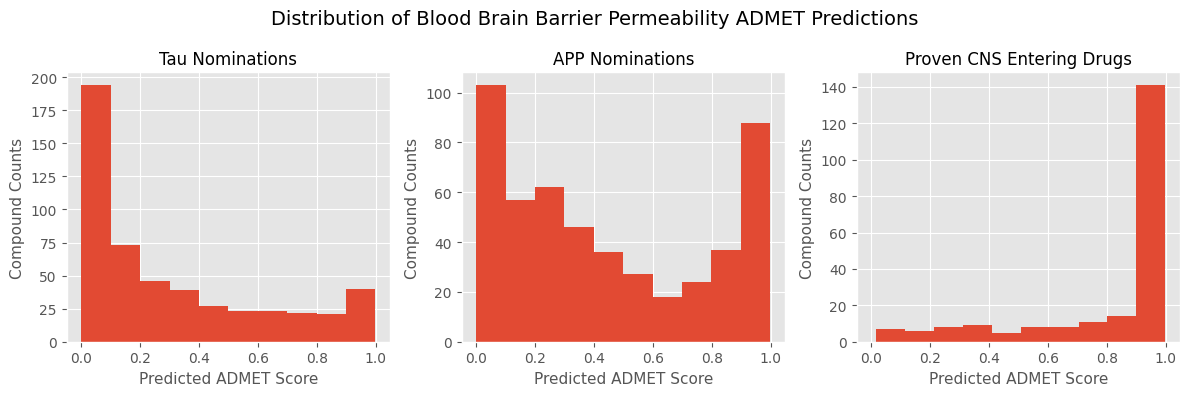

In [8]:

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True, sharex=True)

ax[0].hist(tau_active['BBB'])
ax[0].set_title("Tau Nominations", size=12)

ax[1].hist(app_active['BBB'])
ax[1].set_title(f"APP Nominations", size=12)

ax[2].hist(cns_admet['BBB'])
ax[2].set_title("Proven CNS Entering Drugs", size=12)

fig.suptitle("Distribution of Blood Brain Barrier Permeability ADMET Predictions", size=14)

for subplot in ax:
    subplot.set_xlabel("Predicted ADMET Score", size=11)
    subplot.set_ylabel("Compound Counts", size=11)

# plt.savefig("BBB_ADMET_Pred_Distributions_11Feb2024.png", dpi=400)
### didn't change 11Feb2024 from 11 Jan visual - only flags changed
plt.show()

### Flags for BBB

In [9]:
app_preds_labeled=pd.read_excel("../final_outputs/app_binary_property_flags_11Feb2024.xlsx")
tau_preds_labeled=pd.read_excel("../final_outputs/tau_binary_property_flags_11Feb2024.xlsx")

In [10]:
app_preds_active=app_preds_labeled[app_preds_labeled['prediction']=='Active']
tau_preds_active=tau_preds_labeled[tau_preds_labeled['prediction']=='Active']

In [11]:
cns_flagged=pd.read_excel("../final_outputs/cns_drugs_binary_property_flags_11Feb2024.xlsx")

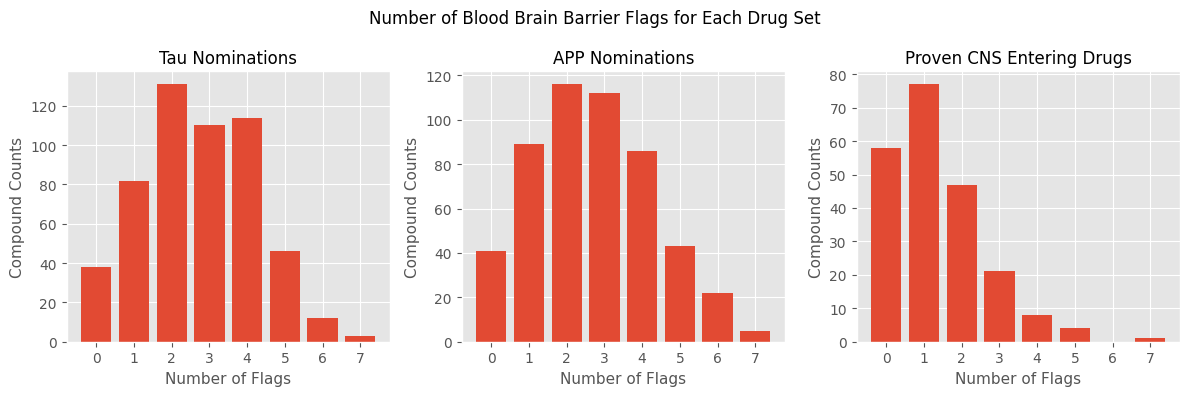

In [14]:

plt.style.use("ggplot")
fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True, sharex=True)
app_comps=app_preds_active['total_flags'].value_counts().sort_index()
tau_comps=tau_preds_active['total_flags'].value_counts().sort_index()

# active_only=preds_labeled[preds_labeled['prediction']=='Active']['total_flags'].value_counts().sort_index()
cns_only=cns_flagged['total_flags'].value_counts().sort_index()

ax[0].bar(tau_comps.index, tau_comps)
ax[0].set_title(f"Tau Nominations", size=12)

ax[1].bar(app_comps.index, app_comps)
ax[1].set_title("APP Nominations", size=12)

ax[2].bar(cns_only.index, cns_only)
ax[2].set_title("Proven CNS Entering Drugs", size=12)
fig.suptitle("Number of Blood Brain Barrier Flags for Each Drug Set")

for subplot in ax:
    subplot.set_xlabel("Number of Flags", size=11)
    subplot.set_ylabel("Compound Counts", size=11)
    subplot.set_xticks([i for i in range(0, app_comps.index.max()+1)])

plt.savefig("BBB_Manual_Flags_11Feb2024.png", dpi=400)

plt.show()

### Scaffold Analysis

https://docs.chemaxon.com/display/docs/bemis-murcko-clustering.md

Bemis and Murcko outlined a popular method for deriving scaffolds from molecules by removing side chain atoms. A molecular framework can be interpreted as a graph containing nodes and edges representing atom and bond types, respectively. Removing atom and bond labels or agglomerating nodes by chemotype yields a hierarchy of reduced graphs, or molecular equivalence classes, that represent sets of related molecules.

#### Question: Can we find consistent scaffolds in the drugs and subsequently prioritize Chembl compounds based on these scaffolds?

In [ ]:
# berberine
Chem.MolFromSmiles("COC1=C(C2=C[N+]3=C(C=C2C=C1)C4=CC5=C(C=C4CC3)OCO5)OC")

In [ ]:
# berberine scaffold
Chem.MolFromSmiles(ms.MurckoScaffoldSmilesFromSmiles("COC1=C(C2=C[N+]3=C(C=C2C=C1)C4=CC5=C(C=C4CC3)OCO5)OC"))

In [ ]:
prediction_set=pd.read_pickle("/home/paperspace/Desktop/DL_Project/data/full_prediction_set_fp_graphs.pickle")

In [ ]:
prediction_set['scaffold']=prediction_set['uncharged_smiles'].apply(lambda x: ms.MurckoScaffoldSmilesFromSmiles(x))
prediction_set['scaffold']=prediction_set['scaffold'].replace("", 'no scaffold')

In [ ]:
top_scaffolds_df=pd.DataFrame(prediction_set['scaffold'].value_counts())
top_scaffolds=top_scaffolds_df.index[1:5]
display(top_scaffolds_df)

In [ ]:
def visualize(smiles: str) -> None:
    print(smiles)
    return display(Chem.MolFromSmiles(smiles))

def get_mw(smiles: str) -> float:

    return ExactMolWt(Chem.MolFromSmiles(smiles))

In [ ]:
prediction_set['molecular_weight']=prediction_set['uncharged_smiles'].apply(lambda x: get_mw(x))

In [ ]:
[visualize(i) for i in top_scaffolds]

In [ ]:
### Steps:

## nominate FDA approved - then perform tanimoto similarity and pick handful of chembl compounds that are most similar